# Predicting Plant Stress with Machine Learning
### Data 602
#### Maxfield Raynolds

## Abstract

This study investigates environmental and nutrient factors that contribute to plant stress and develops predictive models to classify stress level based on these conditions. Effective management of plant stress is essential for growers, and identifying which factors most strongly influence stress can support more consistent plant health.

Ten plants were monitored every six hours. At each interval, eleven environmental and nutrient features were recorded, and a qualitative stress rating was assigned as Low, Moderate, or High. Analysis revealed an association between stress level and three key features: moisture, nitrogen, and phosphorus.

Several machine learning models were evaluated for their ability to predict stress level from these features. Logistic Regression achieved 77% accuracy, Support Vector Machines achieved 82%, and K-Nearest Neighbors reached 92%. Applying Recursive Feature Elimination with K-Nearest Neighbors improved accuracy to 94%.

While these results demonstrate that plant stress can be predicted reliably within this controlled dataset, their generalizability is limited to this specific plant variety and environmental context.

## Introduction

This paper answers two questions for a given dataset: 1. which environmental factors have a direct early impact on plant stress levels? and 2. Can a plant stress level be reliably predicted based on environmental factors?

Agricultural growers and farmers are tasked with producing healthy plants. Modern agriculture has incorporated extensive use of sensors for monitoring environmental factors. This produces an enormous amount of data which may or may not have direct correlation on a plant's stress level.

Generally no individual measured metric will be perfectly consistent creating a potential for complex interactions between environmental factors that affect plant stress. For growers, it is important to understand which factors affect plant stress sooner than others when out of range. Additionally, being able to predict the plant stress based on the data will help growers to proactively takes steps to both anticipate and react quickly to plant stress, allowing them to produce a healthier more consistent crop.

The data used for this paper included monitoring eleven features of ten plants every six hours over XXXXXX days



## Exploratory Data Analysis

In [64]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

In [6]:
# Set the file path for the specific datafile
file_path = 'plant_health_data.csv'

# Import the dataset from kaggle
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,'ziya07/plant-health-data', file_path)

df.to_csv('plant_health_data.csv')

In [7]:
print(f'The data has {df.shape[1]} columns, and {df.shape[0]} rows.')


The data has 14 columns, and 1200 rows.


Below are the columns and the first five rows of the data, showing a timestamp, plant_id, eleven features, and the stress level.

In [8]:
# View the first five lines of the dataset
df.columns = df.columns.str.lower()
df.head()

,timestamp,plant_id,soil_moisture,ambient_temperature,soil_temperature,humidity,light_intensity,soil_ph,nitrogen_level,phosphorus_level,potassium_level,chlorophyll_content,electrochemical_signal,plant_health_status
0,2024-10-03 10:54:53.407995,1,27.521109,22.240245,21.900435,55.291904,556.172805,5.581955,10.003650,45.806852,39.076199,35.703006,0.941402,High Stress
1,2024-10-03 16:54:53.407995,1,14.835566,21.706763,18.680892,63.949181,596.136721,7.135705,30.712562,25.394393,17.944826,27.993296,0.164899,High Stress
2,2024-10-03 22:54:53.407995,1,17.086362,21.180946,15.392939,67.837956,591.124627,5.656852,29.337002,27.573892,35.706530,43.646308,1.081728,High Stress
3,2024-10-04 04:54:53.407995,1,15.336156,22.593302,22.778394,58.190811,241.412476,5.584523,16.966621,26.180705,26.257746,37.838095,1.186088,High Stress
4,2024-10-04 10:54:53.407995,1,39.822216,28.929001,18.100937,63.772036,444.493830,5.919707,10.944961,37.898907,37.654483,48.265812,1.609805,High Stress


There are ten plants that are monitored and each has 120 observations.

In [12]:
df.groupby('plant_id').size()

plant_id
1     120
2     120
3     120
4     120
5     120
6     120
7     120
8     120
9     120
10    120
dtype: int64

A summary of the numeric data.

In [137]:
df.drop(columns=['plant_id']).describe()

,soil_moisture,ambient_temperature,soil_temperature,humidity,light_intensity,soil_ph,nitrogen_level,phosphorus_level,potassium_level,chlorophyll_content,electrochemical_signal
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,25.106918,23.999130,19.957794,54.853165,612.637265,6.524102,30.106751,30.264484,30.112088,34.749591,0.987764
std,8.677725,3.441561,2.932073,8.784916,228.318853,0.581755,11.514396,11.466846,11.668085,8.766995,0.575116
min,10.000724,18.001993,15.003710,40.028758,200.615482,5.507392,10.003650,10.017690,10.000606,20.025511,0.002376
25%,17.131893,21.101766,17.353027,47.019694,416.878983,6.026042,20.249774,20.894445,19.585561,27.463350,0.487982
50%,25.168333,23.889044,19.911473,54.692069,617.240221,6.540524,30.138590,30.019385,30.495054,34.433427,0.981647
75%,32.370231,27.042634,22.596851,62.451053,811.474690,7.030039,40.184737,40.131459,40.108296,42.232637,1.473142
max,39.993164,29.990886,24.995929,69.968871,999.856262,7.497823,49.951136,49.980700,49.981945,49.990811,1.996116


Below is a look at the count of each stress level for each plant.

In [138]:
# Look at aggregated counts of stress levels by plant id
df.groupby(['plant_id', 'plant_health_status'], observed = False).agg(
    count = ('plant_health_status', 'count')).reset_index().pivot(index='plant_id', columns='plant_health_status', values='count')

plant_health_status,Healthy,High Stress,Moderate Stress
plant_id,,,
1,24,50,46
2,36,53,31
3,39,41,40
4,28,46,46
5,29,50,41
6,29,46,45
7,30,55,35
8,28,52,40
9,28,57,35


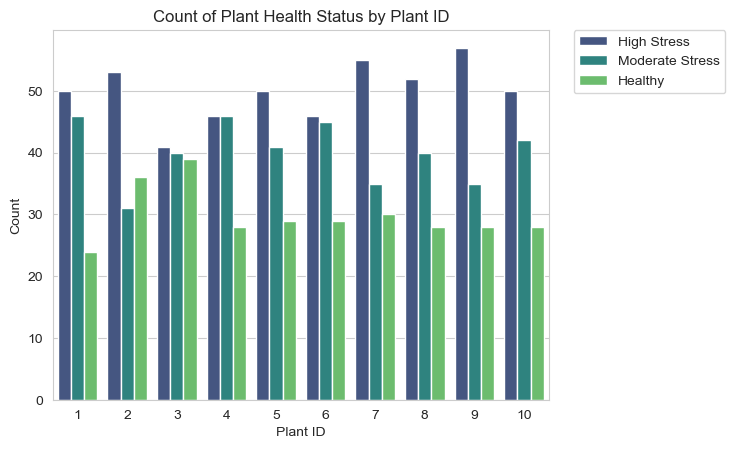

In [31]:
ax = sns.countplot(data=df,  x='plant_id', hue='plant_health_status', palette='viridis')
plt.title('Count of Plant Health Status by Plant ID')
plt.xlabel('Plant ID')
plt.ylabel('Count')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In order to understand what the values are for each feature by stress level, all features are plotted in a violin plot separated by stress level.

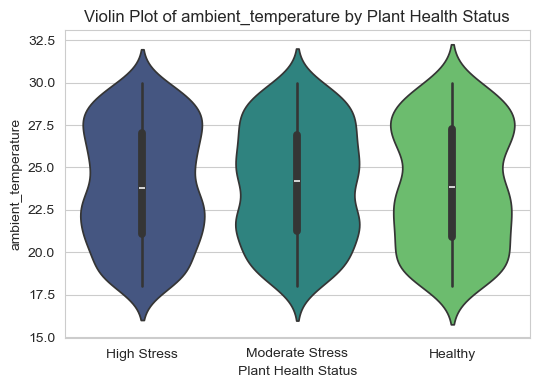

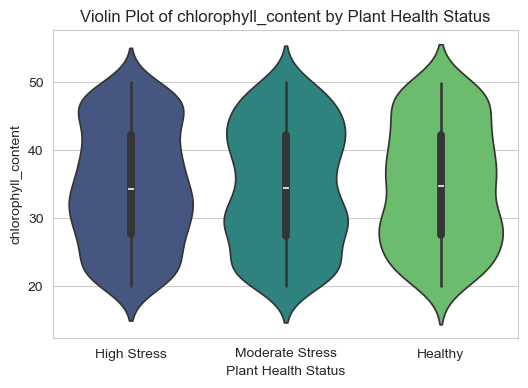

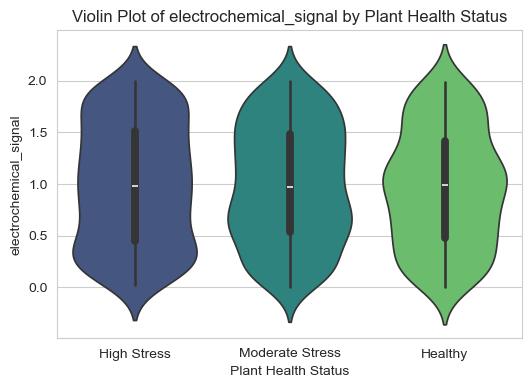

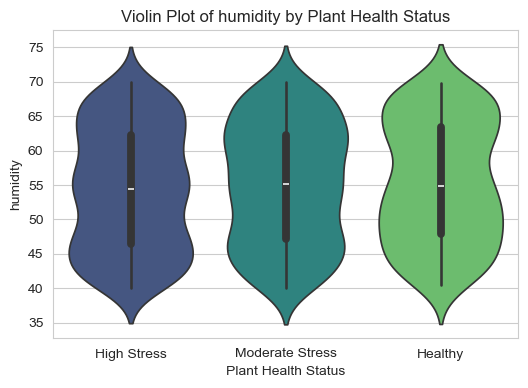

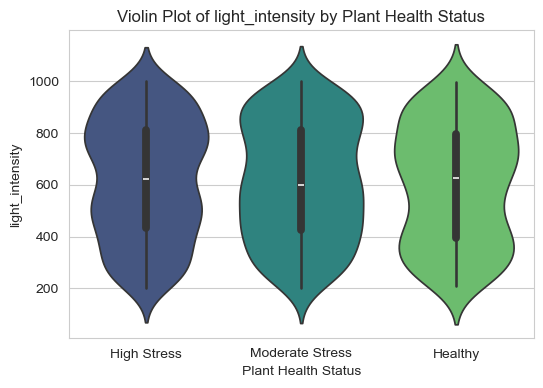

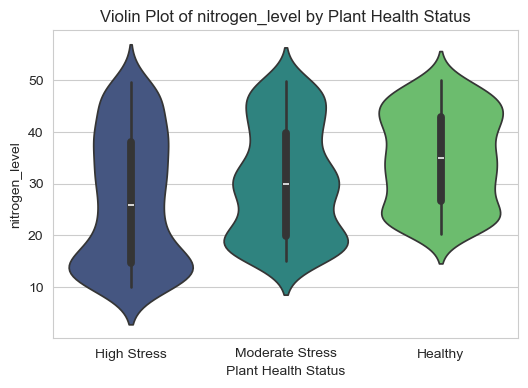

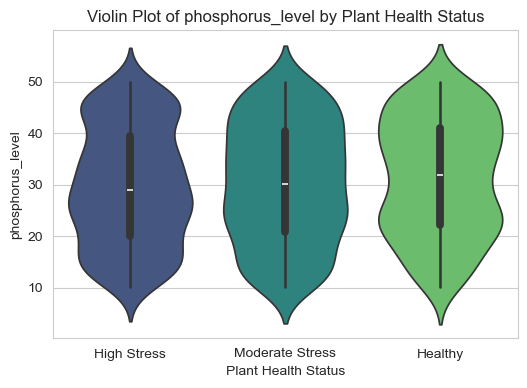

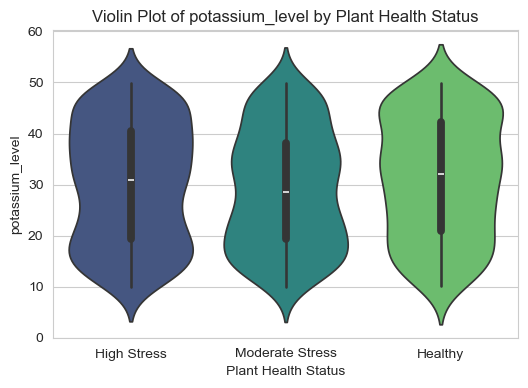

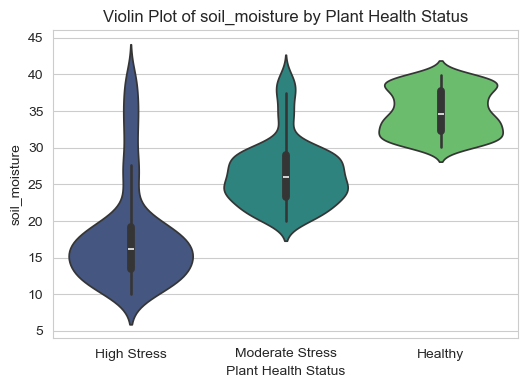

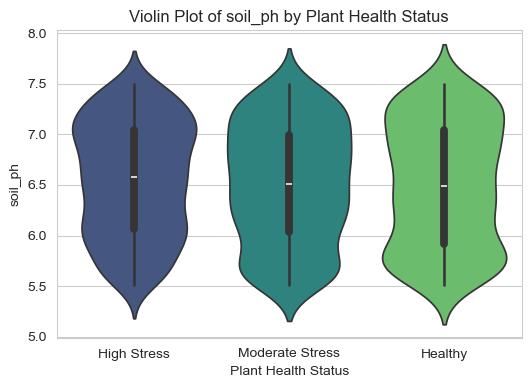

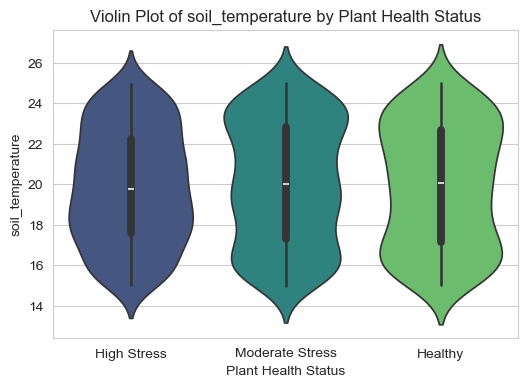

In [35]:
# Violin plot of all features plotted against plant_health_status
y_features = df.columns.difference(['timestamp', 'plant_id','plant_health_status']).to_list()

for y in y_features:
    plt.figure(figsize=(6,4))
    sns.violinplot(data=df, x='plant_health_status', y=y, hue='plant_health_status', palette='viridis')
    plt.title(f'Violin Plot of {y} by Plant Health Status')
    plt.xlabel('Plant Health Status')
    plt.show()

The majority of the violin plots look similar and not distinct from each other. However, two features, soil moisture and nitrogen level, show distinct shapes in relation to one another at different stress levels.

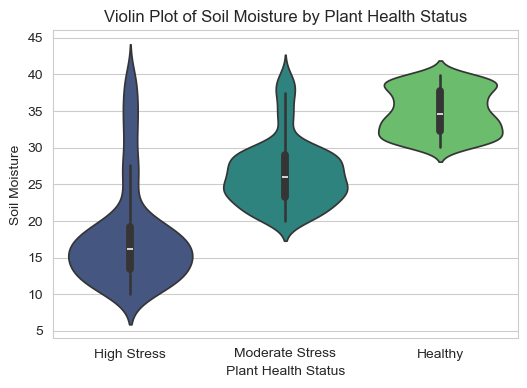

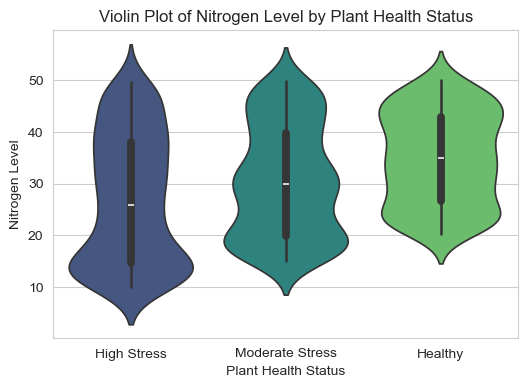

In [46]:
# Two violin plots of interest
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x = 'plant_health_status', y = 'soil_moisture', hue='plant_health_status', palette='viridis')
plt.title('Violin Plot of Soil Moisture by Plant Health Status')
plt.xlabel('Plant Health Status')
plt.ylabel('Soil Moisture')
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x = 'plant_health_status', y = 'nitrogen_level', hue='plant_health_status', palette='viridis')
plt.title('Violin Plot of Nitrogen Level by Plant Health Status')
plt.xlabel('Plant Health Status')
plt.ylabel('Nitrogen Level')
plt.show()

These two violin plots indicate that plants with low soil moisture and low nitrogen level are both more likely to be experiencing high stress. This observation can be further examined using a heatmap to examine correlation between all features and the stress level.

In [47]:
# Encode stress levels as numbers
from sklearn.preprocessing import LabelEncoder

df['stress_encoded'] = LabelEncoder().fit_transform(df['plant_health_status'])
metric_features = df.drop(columns = ['timestamp','plant_health_status', 'plant_id','stress_encoded']).columns.tolist()

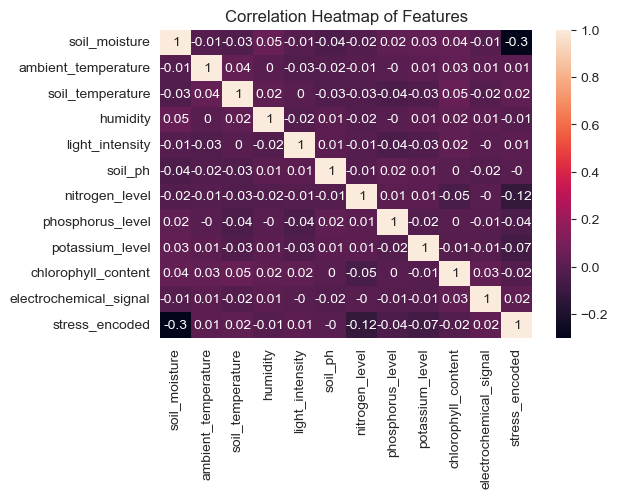

In [48]:
# Plot of a correlation heatmap between features and stress
plt.figure(figsize=(6,4))
sns.heatmap(df[metric_features + ['stress_encoded']].corr().round(2), annot=True)
plt.title('Correlation Heatmap of Features')
plt.show()

The heatmap above shows the strongest correlations as negative correlations between stress level and both soil moisture and nitrogen level. This is what the violin plots also indicated. In order to identify whether these correlations are significant the p-values should be considered.

In [54]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Create a categorical hierarchy for the plant_health_status
order = ['Healthy', 'Moderate Stress', 'High Stress']
cat_type = pd.CategoricalDtype(categories=order, ordered=True)
df['plant_health_status'] = df['plant_health_status'].astype(cat_type)

# Establish the features and target variable
feature_cols = ['soil_moisture', 'ambient_temperature', 'soil_temperature', 'humidity', 'light_intensity', 'soil_ph',
                'nitrogen_level', 'phosphorus_level', 'potassium_level', 'chlorophyll_content',
                'electrochemical_signal']
X = df[feature_cols]
y = df['plant_health_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

model_ord = OrderedModel(
    y_train,
    X_train,
    distr='logit'
)

result_ord = model_ord.fit(method='bfgs')
print(result_ord.summary())

Optimization terminated successfully.
         Current function value: 0.532071
         Iterations: 44
         Function evaluations: 51
         Gradient evaluations: 51
                              OrderedModel Results                             
Dep. Variable:     plant_health_status   Log-Likelihood:                -478.86
Model:                    OrderedModel   AIC:                             983.7
Method:             Maximum Likelihood   BIC:                             1046.
Date:                 Wed, 10 Dec 2025                                         
Time:                         21:28:17                                         
No. Observations:                  900                                         
Df Residuals:                      887                                         
Df Model:                           11                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
------------

Next, density histograms of each feature was plotted with the proportion of plant health stress for each bin.

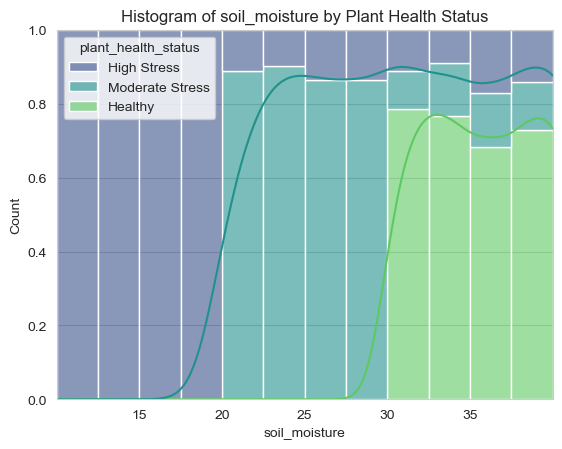

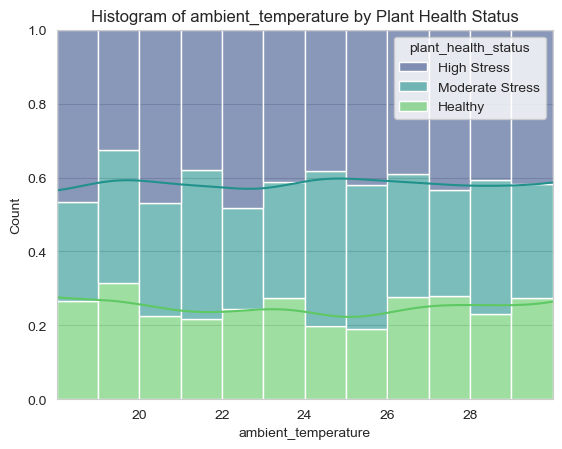

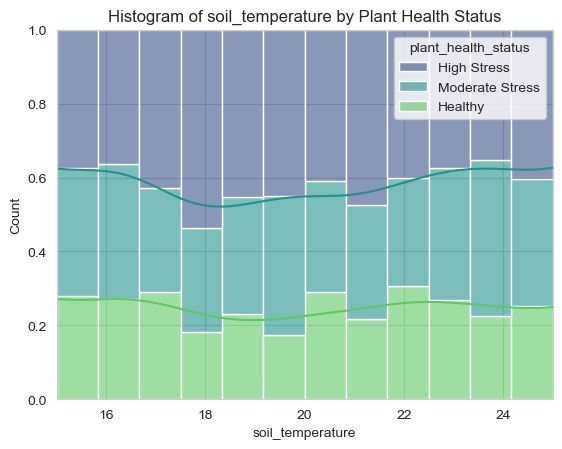

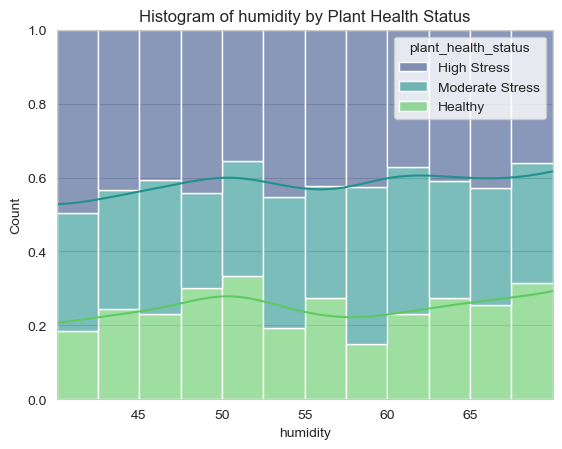

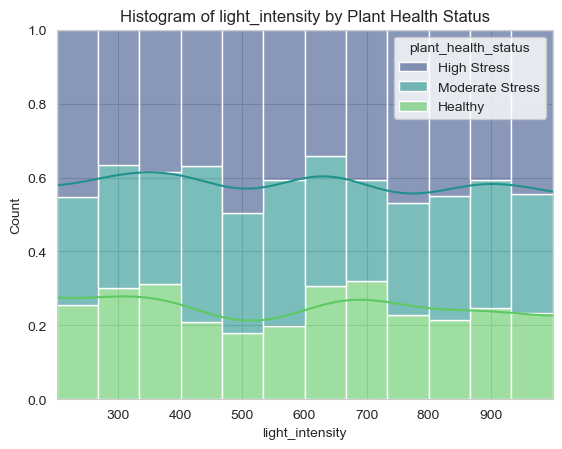

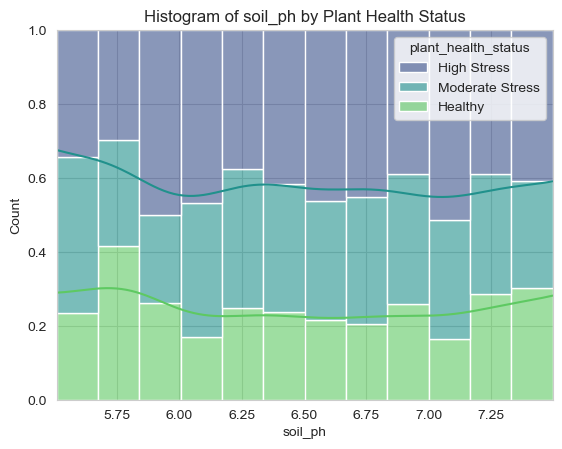

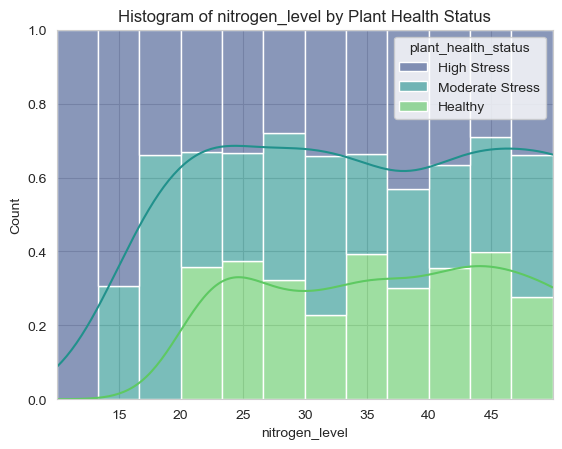

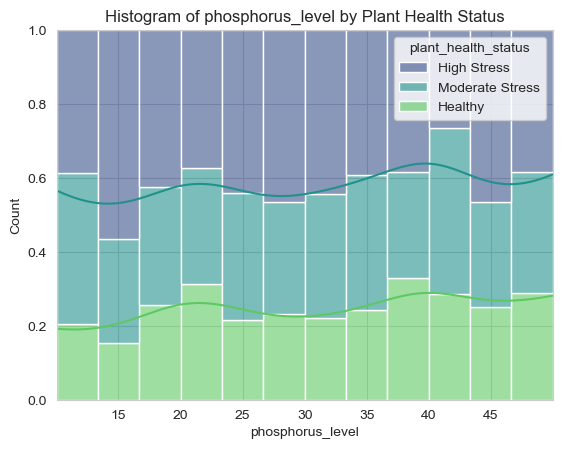

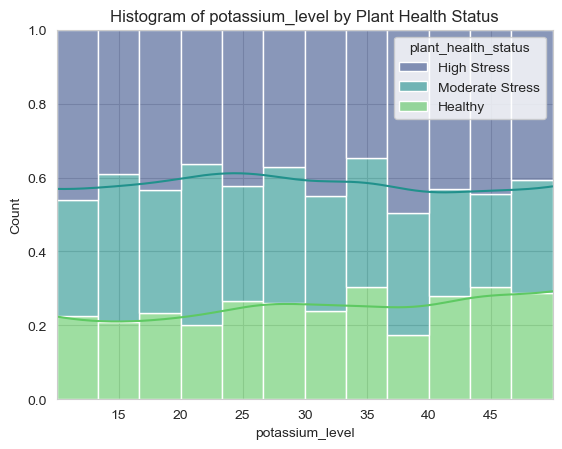

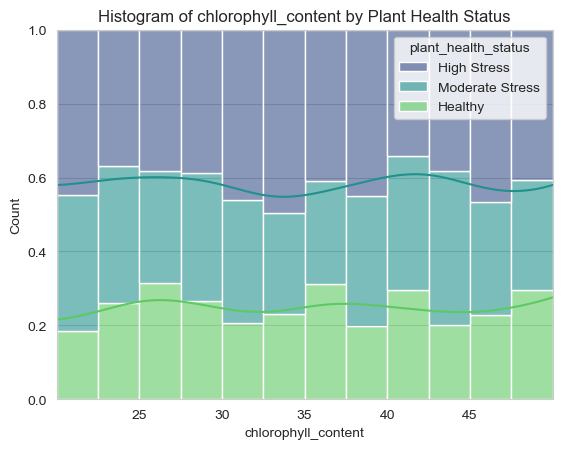

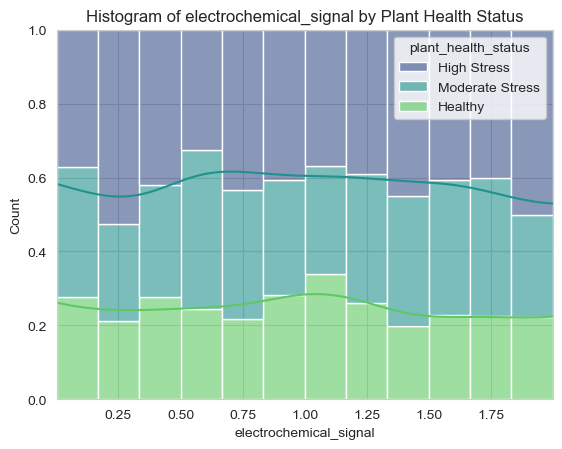

In [49]:
 # A for loop plots a proportional histogram
 for col in metric_features:
     sns.histplot(data=df, x=col, hue='plant_health_status', kde=True, alpha=0.6, multiple='fill', palette='viridis')
     plt.title(f'Histogram of {col} by Plant Health Status')
     plt.show()

The histogram results are similar to the violin plots. Most histograms show a relatively consistent distribution of stress levels. There is no obvious pattern. Again the exceptions were the soil moisture and nitrogen level. Both of those histograms are shown again below. It is clear that at lower levels of soil moisture and nitrogen levels there are fewer plants that are considered "Healthy" and more that are "Moderate" or "High Stress".

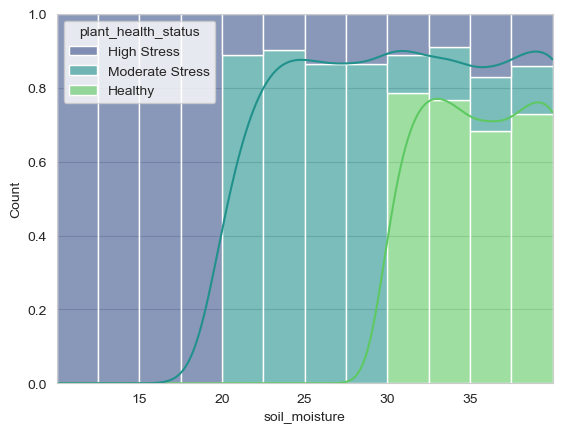

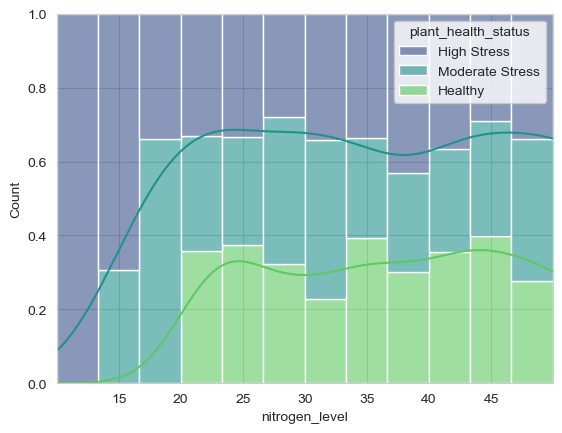

In [143]:
sns.histplot(data=df, x='soil_moisture', hue='plant_health_status', kde=True, alpha=0.6, multiple='fill', palette='viridis')
plt.show()
sns.histplot(data=df, x='nitrogen_level', hue='plant_health_status', kde=True, alpha=0.6, multiple='fill', palette='viridis')
plt.show()

## Data Wrangling

Overall, this data set is relatively tidy.

There is no missing data within the dataset.

In [149]:
# Inspect dataset for missing values
df.isna().any()

timestamp                 False
plant_id                  False
soil_moisture             False
ambient_temperature       False
soil_temperature          False
humidity                  False
light_intensity           False
soil_ph                   False
nitrogen_level            False
phosphorus_level          False
potassium_level           False
chlorophyll_content       False
electrochemical_signal    False
plant_health_status       False
stress_encoded            False
dtype: bool

All of the data types are appropriate.

In [150]:
# Inspect data types
df.dtypes

timestamp                 datetime64[ns]
plant_id                           int64
soil_moisture                    float64
ambient_temperature              float64
soil_temperature                 float64
humidity                         float64
light_intensity                  float64
soil_ph                          float64
nitrogen_level                   float64
phosphorus_level                 float64
potassium_level                  float64
chlorophyll_content              float64
electrochemical_signal           float64
plant_health_status               object
stress_encoded                     int64
dtype: object

The code below creates a categorical hierarchy for the plant_health_status column.

In [152]:
# Create a categorical hierarchy for the plant_health_status
order = ['Healthy', 'Moderate Stress', 'High Stress']
cat_type = pd.CategoricalDtype(categories=order, ordered=True)
df['plant_health_status'] = df['plant_health_status'].astype(cat_type)

The following code shortens the timestamp. The seconds and fractions of a second are an unnecessary level of precision for this analysis.

In [153]:
# Shorten date and timestamp to just date and hours and minutes
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
df['timestamp'] = pd.to_datetime(df['timestamp'])


# View the shape of the datasets
print(df.shape)

(1200, 15)


As the code indicate below the plants were monitored for 29 days and 18 hours.

In [154]:
df.groupby('plant_id')['timestamp'].agg(lambda x: x.max() - x.min())

plant_id
1    29 days 18:00:00
2    29 days 18:00:00
3    29 days 18:00:00
4    29 days 18:00:00
5    29 days 18:00:00
6    29 days 18:00:00
7    29 days 18:00:00
8    29 days 18:00:00
9    29 days 18:00:00
10   29 days 18:00:00
Name: timestamp, dtype: timedelta64[ns]

## Data Analysis

### Recursive Feature Elimination with Logistic Regression and Cross Validation of Scaled Features

In the exploratory data analysis it appeared as though there were two features that were potential indicators of high stress. While they were not exclusive to high stress, plants with low soil moisture and low nitrogen were less likely to have healthy or moderate stress status.

Considering most features appeared to not have a significant corollary relationship with health status Recursive Feature Elimination was performed on Logistic Regression using a for loop, scaled features, and cross validation to analyze what combination of features would yield the most accurate results for Logistic Regression.

     n      mean                                  selected_features
1    2  0.769167                    [soil_moisture, nitrogen_level]
3    4  0.764167  [soil_moisture, soil_temperature, nitrogen_lev...
4    5  0.763333  [soil_moisture, ambient_temperature, soil_temp...
5    6  0.760000  [soil_moisture, ambient_temperature, soil_temp...
8    9  0.759167  [soil_moisture, ambient_temperature, soil_temp...
2    3  0.758333  [soil_moisture, soil_temperature, nitrogen_level]
6    7  0.756667  [soil_moisture, ambient_temperature, soil_temp...
9   10  0.755000  [soil_moisture, ambient_temperature, soil_temp...
7    8  0.755000  [soil_moisture, ambient_temperature, soil_temp...
10  11  0.753333  [soil_moisture, ambient_temperature, soil_temp...
0    1  0.748333                                    [soil_moisture]


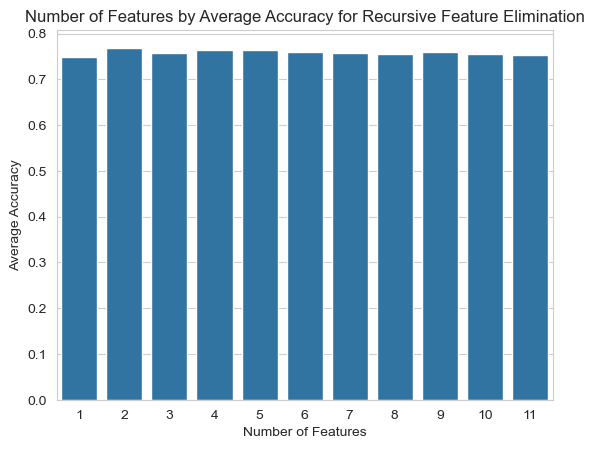

In [67]:
# Features and target
feature_cols = ['soil_moisture','ambient_temperature','soil_temperature','humidity',
                'light_intensity','soil_ph','nitrogen_level','phosphorus_level',
                'potassium_level','chlorophyll_content','electrochemical_signal']
X = df[feature_cols]
y = df['plant_health_status']

# Scale features
X_scaled = StandardScaler().fit_transform(X)

# Instantiate Logistic Regression
logreg = LogisticRegression(max_iter=10000)

# Test numbers of features using a for loop and RFE
results = []
for n in range(1, 12):
    rfe = RFE(logreg, n_features_to_select=n)
    X_rfe = rfe.fit_transform(X_scaled, y)

    cv_scores = cross_val_score(logreg, X_rfe, y, cv=5)
    mean_score = cv_scores.mean()

    selected_features = np.array(feature_cols)[rfe.support_]
    results.append({
        'n':n,
        'mean': mean_score,
        'selected_features': selected_features
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mean', ascending=False))

sns.barplot(data=results_df, x='n',y='mean')
plt.title('Number of Features by Average Accuracy for Recursive Feature Elimination')
plt.xlabel('Number of Features')
plt.ylabel('Average Accuracy')
plt.show()

### Logistic Regression

The results of the logistic regression with cross validation and RFE show that the most accurate combination of features was the same two features that appeared to be important during the exploratory data analysis: soil moisture and nitrogen level. The combination of these features led to an accuracy of ~76.9%.

Below is the full results of a Logistic Regression using the two features.

                 precision    recall  f1-score   support

        Healthy       0.83      0.75      0.79        67
Moderate_stress       0.84      0.85      0.84       104
    High_stress       0.60      0.65      0.62        69

       accuracy                           0.76       240
      macro avg       0.76      0.75      0.75       240
   weighted avg       0.77      0.76      0.76       240



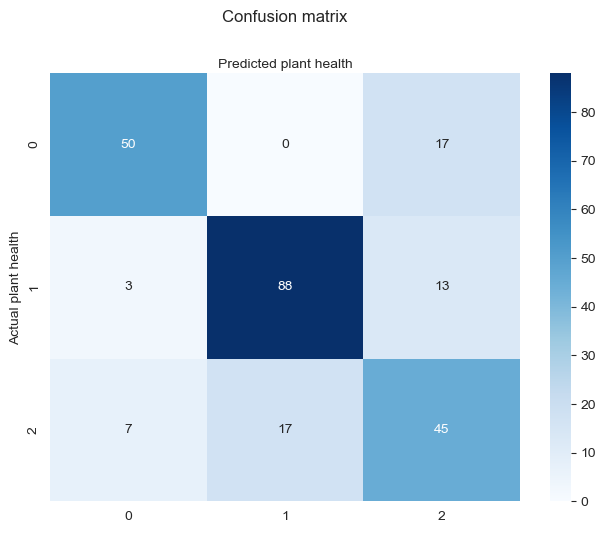

In [217]:
# Logistic Regression with Soil Moisture and Nitrogen Level

# Set features and target
feature_cols = ['soil_moisture', 'nitrogen_level']

X = df[feature_cols]
y = df['plant_health_status']

#Scale features
X_scaled = StandardScaler().fit_transform(X)

# Split train and test sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1234)

# Instantiate Logistic Regression model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_scaled, y_train)

# Predict y
y_pred = logreg.predict(X_test_scaled)

# Extract confusion matrix and classification report
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = ['Healthy', 'Moderate_stress','High_stress']
class_report = classification_report(y_test, y_pred, target_names=class_names)

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual plant health')
plt.xlabel('Predicted plant health')

print(class_report)
plt.show()

The classification report and the confusion matrix show the performance of the logistic regression model.
The model predicts the plant health status with mixed results, with an average accuracy of 76%.
The model struggles the most with predicting the high stress category.

While 76% is not terrible, there is room for improvement.

### Support Vector Machines

The next predictive model applied to the data was Support Vector Machines, using the same features selected during RFE.

                 precision    recall  f1-score   support

        Healthy       1.00      0.97      0.98        67
Moderate_stress       0.99      0.98      0.99       104
    High_stress       0.94      0.99      0.96        69

       accuracy                           0.98       240
      macro avg       0.98      0.98      0.98       240
   weighted avg       0.98      0.98      0.98       240



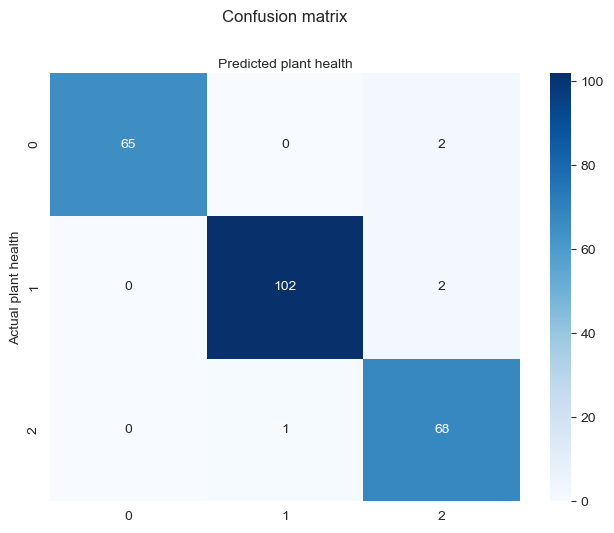

In [219]:
# SVM with Soil Moisture and Nitrogen Level

# Set features and target
feature_cols = ['soil_moisture', 'nitrogen_level']

X = df[feature_cols]
y = df['plant_health_status']

#Scale features
X_scaled = StandardScaler().fit_transform(X)

# Split train and test sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1234)

# Instantiate SVM model
svm = SVC(random_state=1234)
svm.fit(X_train_scaled, y_train)

# Predict y
y_pred = svm.predict(X_test_scaled)

# Extract confusion matrix and classification report
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = ['Healthy', 'Moderate_stress','High_stress']
class_report = classification_report(y_test, y_pred, target_names=class_names)

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual plant health')
plt.xlabel('Predicted plant health')

print(class_report)
plt.show()

The Support Vector Machines model is performing exceptionally well. Overall accuracy is 98%. Precision for Healthy and Moderate Stress plants is nearly perfect. For High Stress plants precision is slightly lower but still good at 94%.

Ultimatley, this model's performance was excellent and is likely adequate to use as a model in this growing context for predicting plant health status

### K-Nearest Neighbors

Finally, K-Nearest Neighbors was applied to the model using the same two features: soil moisture and nitrogen level.

First cross validation was applied to determine the best k-value.

Best k value: 15
Best score: 0.971875


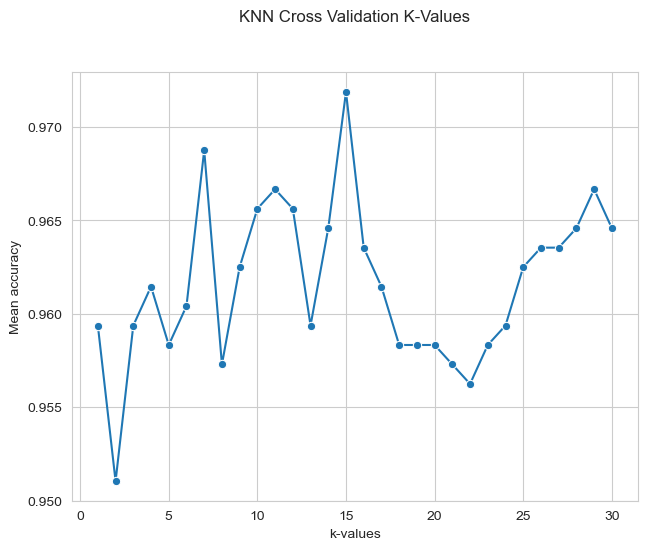

In [228]:
# KNN cross_validation

feature_cols = ['soil_moisture', 'nitrogen_level']

X = df[feature_cols]
y = df['plant_health_status']

k_values = [i for i in range (1,31)]
scores = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    scores.append(np.mean(score))

best_k = k_values[np.argmax(scores)]
best_score = max(scores)
print('Best k-value:', best_k)
print('Best score:', best_score)

sns.lineplot(x=k_values, y=scores, marker = 'o')
plt.tight_layout()
plt.title('KNN Cross Validation K-Values', y=1.1)
plt.ylabel('Mean accuracy')
plt.xlabel('k-values')
plt.show()

The cross validation on the scaled test found a k-value of 15 had the best accuracy of approximately 97%.

The KNN model was then applied to the dataset using the best k-value of 15 to confirm the results.

KNN Accuracy: 0.9708333333333333
                 precision    recall  f1-score   support

        Healthy       1.00      0.96      0.98        67
Moderate_stress       0.96      1.00      0.98       104
    High_stress       0.96      0.94      0.95        69

       accuracy                           0.97       240
      macro avg       0.97      0.97      0.97       240
   weighted avg       0.97      0.97      0.97       240



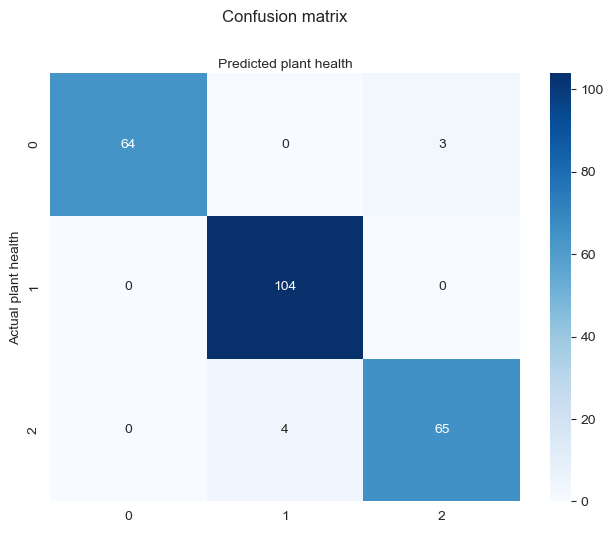

In [230]:
# KNN with k-value of 15
feature_cols = ['soil_moisture', 'nitrogen_level']

X = df[feature_cols]
y = df['plant_health_status']

k_values = [i for i in range (1,31)]
scores = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, y_pred)
print('KNN Accuracy:', knn_accuracy)

# Extract confusion matrix and classification report
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = ['Healthy', 'Moderate_stress','High_stress']
class_report = classification_report(y_test, y_pred, target_names=class_names)

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual plant health')
plt.xlabel('Predicted plant health')

print(class_report)
plt.show()

The application of KNN with a k-value 15 yields an accuracy of 97%, as expected. This model also performed exceptionally. The potential for the SVM and the KNN model to be used in tandem in order to predict the plant health status is well advised and will generally lead to very accurate predictions on the plant health status.

## Conclusion

A vital part of modern agriculture is tracking environmental factors amd their influence on plant health and stress. For this study a dataset featuring eleven environmental factors and a three tiered qualitative plant stress level assessment was examined. Initial analysis indicated that the majority of environmental factors were not immediately correlated with the plant stress level. Only two features, soil moisture and nitrogen level, appeared to have direct correlation with the plant stress level. Using recursive feature elimination it was confirmed that soil moisture and nitrogen level were the most useful factors for predicting plant health stress. These features were then used in a logistic regression with a 76% accuracy, a Support Vector Machines (SVM) model with a 98% accuracy, and a K-Nearest Neighbors (KNN) model with a 97% accuracy.

SVM an KNN performed exceptionally and would be useful tools for predicting the plant health status based on new data. There are caveats to this recommendation. These models would potentially only be applicable on these same plants in the same environment and while the other features stayed within their approximate ranges listed in this dataset. The non-predictive features should not be considered irrelevant but are not early indicators of plant stress, if one or several were to swing wildly out of their current ranges it may also become a corollary with plant health status.

The accuracy of the predictive model may prove to be useful in many ways. It identifies which features to prioritize monitoring and which ones to react quickly too. It may provide opportunities for changing how and what features are monitored and at what tempo they are monitored. The information may influence decisions related to irrigation and fertilizing strategy. Ultimately, this predictive model has the potential to both assist in identifying but also anticipating plants with higher levels of stress and ultimately preventing that stress.